In [1]:
# Load Extension for noTeXbook theme
%load_ext notexbook

In [2]:
# Enable noTeXbook theme
%texify --code-font Monaco --linespread 1.5

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/pytorch-beautiful-ml-data/pydata-global/?filepath=3_transformer_samplers/transformers_and_samplers.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/3_transformer_samplers/transformers_and_samplers.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/pytorch-beautiful-ml-data/blob/pydata-global/3_transformer_samplers/transformers_and_samplers.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. <br />
Please **Trust** the notebook to automatically enable the theme. If you are viewing this notebook in **Google Colab**, these are the [instructions](https://github.com/leriomaggio/notexbook-jupyter-theme/tree/texbook-colab) to enable the theme in Colab.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introducing-torchvision" data-toc-modified-id="Introducing-torchvision-1">Introducing <code>torchvision</code></a></span><ul class="toc-item"><li><span><a href="#Dataset-and-transform" data-toc-modified-id="Dataset-and-transform-1.1"><code>Dataset</code> and <code>transform</code></a></span><ul class="toc-item"><li><span><a href="#Exercise" data-toc-modified-id="Exercise-1.1.1">Exercise</a></span></li></ul></li><li><span><a href="#Transform,-Random,-and-seeds" data-toc-modified-id="Transformers,-Random,-and-seeds-1.2">Transform, Random, and seeds</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#RandomApply-and-random-transformers" data-toc-modified-id="RandomApply-and-random-transformers-1.2.0.1"><code>RandomApply</code> and random transformers</a></span></li></ul></li></ul></li><li><span><a href="#Further-Readings" data-toc-modified-id="Further-Readings-1.3">Further Readings</a></span></li></ul></li><li><span><a href="#DataLoaders-and-Imbalanced-data" data-toc-modified-id="DataLoaders-and-Imbalanced-data-2">DataLoaders and Imbalanced data</a></span><ul class="toc-item"><li><span><a href="#Sampler" data-toc-modified-id="Sampler-2.1">Sampler</a></span><ul class="toc-item"><li><span><a href="#Sampling-FER-Data" data-toc-modified-id="Sampling-FER-Data-2.1.1">Sampling FER Data</a></span><ul class="toc-item"><li><span><a href="#NO-Sampler" data-toc-modified-id="NO-Sampler-2.1.1.1">NO Sampler</a></span></li><li><span><a href="#Random-Sampler" data-toc-modified-id="Random-Sampler-2.1.1.2">Random Sampler</a></span></li></ul></li></ul></li></ul></li></ul></div>

# Transformers and Samplers

In this notebook we will continue to be working with our `FER` dataset.

In particular, we will start where we left off and will continue improving our abstractions by focusing on `transformers` and more sophisticated **data loading** strategies, to cope with dataset class imbalance.

Let's start by loading the dataset from `fer.py`

**Note**: if opening this notebook from Colab, please refer to this file: $\Rightarrow$ [`fer.py`](https://github.com/leriomaggio/pytorch-beautiful-ml-data/blob/main/3_transformer_samplers/fer.py)

In [3]:
from fer import FER

In [4]:
fer_training = FER(root=".", download=True, split="train")

Extracting FER/raw/fer2013.tar.gz to FER/raw
Processing...
Done!


In [5]:
from collections import namedtuple
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate


Batch = namedtuple("Batch", ["samples", "emotions"])

def batch_collate_fn(batch):
    batch = default_collate(batch)
    return Batch(*batch)

In [6]:
BATCH_SIZE = 256

training_loader = DataLoader(fer_training, batch_size=BATCH_SIZE, 
                             shuffle=False, drop_last=False,
                             collate_fn=batch_collate_fn)

If we now get out first batch of data

In [7]:
batch = next(iter(training_loader))

In [8]:
batch.samples.shape

torch.Size([256, 1, 48, 48])

In [9]:
batch.emotions.shape

torch.Size([256])

## Introducing `torchvision`

With this implementation, everything is fine indeed. Plus, ultimately we are dealing with `torch.Tensor` which is **the** data format that is required by `torch.nn.Module` for training/validation.

However, what if we would apply any (`Random`?) **preprocessing** transformation to each image before it is transformed to a `torch.Tensor`; not to mention a whole pipeline of **data augmentation** ?

Each sample in the `FER` dataset is an (grayscale) image, and `torchvision` is the **PyTorch** extension specifically for computer vision. 

In particular, `torchvision` provides what it calls `Transformers`, simple `Callable` objects very easy to use and implement, that have been designed exactly with this scenario in mind. 

`torchvision.transforms` classes can be organised in three main categories:

- Transforms on `PIL.Image` **only** -- `Callable` objects
- Transforms on `torch.Tensor` **only** - `nn.Module` subclasses, and also `torch.jit.scriptable`
- Transforms on `PIL Image` and `torch.Tensor` (typically `nn.Module` subclasses)

Plus: (1) _Compositional_ transformers, and (2) _Functional_ transformers, i.e. functional versions of the OOP-based ones.

The **full list** of [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) is available in the official documentation.

More on `TorchScript` here: [tutorial](https://pytorch.org/tutorials/beginner/Intro_to_TorchScript_tutorial.html)

---

Integrating a `transformer` is very easy, as it is also very easy to develop your own _custom_ transformers.

We will try to do both in the next few minutes

### `Dataset` and `transform`

Integrating `transformers` and preprocessing into `Dataset` is very easy, and it is also result of good data structures abstractions, once again 😊

The way we will use to integrate transformers is similar to what `datasets` included in `torchvision` do, i.e. `torchvision.datasets.VisionDataset`

In [10]:
from typing import Optional, Callable

from torchvision.datasets import VisionDataset
from PIL import Image

class FERVision(FER, VisionDataset):
    
    def __init__(self, root: str = ".", download: bool = True, split: str = "train", 
                 transform: Optional[Callable] = None) -> None:
        FER.__init__(self, root=root, download=download, split=split)
        VisionDataset.__init__(self, root=root, transform=transform)
        
    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        if self.transform is not None:
            img = self.transform(img)
        return img, target
    
        

Easy, eh?! 🙌

Now we will start injecting a very simple transformer, `toTensor` which transforms the input `PIL.Image` into a `torch.Tensor`.

In [11]:
from torchvision.transforms import ToTensor

In [12]:
fer_vision_training = FERVision(root=".", download=True, split="train", transform=ToTensor())

Extracting FERVision/raw/fer2013.tar.gz to FERVision/raw
Processing...Done!


In [13]:
vision_train_loader = DataLoader(fer_vision_training, batch_size=BATCH_SIZE, 
                                 shuffle=False, drop_last=False,
                                 collate_fn=batch_collate_fn)

In [14]:
batch = next(iter(vision_train_loader))
batch.samples.shape, batch.emotions.shape

(torch.Size([256, 1, 48, 48]), torch.Size([256]))

OK: _so far, so good_. 

Nothing has really changed apparently, apart from the fact that if we _instantiate_ the `FERVision` dataset with no `transform`, a `PIL.Image` will be returned.

---

#### Exercise

As an excercise, try to instantiate a `FERVision` dataset with no `transform`. This should be quite easy to do ;). 

In [15]:
# your code here

Now, try to create a `DataLoader` for this dataset, also using the `default_collate_fn` function as `collate_fn` parameter. Could you guess what can happen? 

_hint_: this is not going to work! 

Try to implement a custom **collate_fn** function to allow the `dataset` and the `dataloader` to be working together to generate data batches.

In [16]:
# your code here

---

### Transformers, Random, and seeds

Let's now start integrating into our `FERVision` dataset two more transformers:

- [`RandomAffine`](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomaffine#torchvision.transforms.RandomAffine)
- [`ColorJitter`](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=colorjitter#torchvision.transforms.ColorJitter)
 

The _former_ applies a random [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) to the input image/tensor, keeping center invariant, whereas the _latter_ randomly change the brightness, contrast and saturation of an input image/ tensor.

Moreover, we also want to combine a [`RandomApply`](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=randomapply#torchvision.transforms.RandomApply) transformer to this pipeline, to apply these transformations according to some `probability` threshold.

💡 All of these transformers are `jit.scriptable` (extending `torch.nn.Module`), and so we could leverage on this feature too!

##### `RandomApply` and random transformers

The current implementation of `random` transformers, i.e. transformer which are randomly applied according to a certain probability threshold, expects that the parameter `p: float = 0.5` for the probability is specified.

In particular: 

```python 
    if torch.rand(1) < self.p:
        return self.transform(img)
    return img  # no transformation applied
```

This is the general implementation, and the *random* number generated to control the transformation leverages on the **global** random seed (if specified).

Therefore it is usual practice to **fix** a global random seed to guarantee **determinism** and **replicability**, and use that in transformers too.

See also [this](https://stackoverflow.com/questions/59516181/fix-random-seed-for-torchvision-transforms) issue on StackOverflow

However, I personally argue this is a good design in general, as it should be possible to control or specify the `random.seed` as well as the `torch.Generator` object to draw from the distribution.

Therefore, _imho_, whenever you would have a `Random` Transformer to apply, always provide the seed or the generator to be working with. Ultimately, _fallback_ with the global one anyway.

In [17]:
import torch
import numpy as np

In [18]:
from torchvision.transforms import RandomAffine, ColorJitter, RandomApply

In [19]:
class LocalRandomApply(RandomApply):
    """Custom RandomApply transformer using a 
    "Local" torch.Generator for probability
    """
    def __init__(self, transforms, p=0.5, seed: int = None, generator : torch.Generator = None):
        super().__init__(transforms=transforms, p=p)
        if seed is None:
            seed = torch.random.seed()  # get current seed
        self.seed = seed
        if generator is None:
            self.generator = torch.Generator()
        else:
            self.generator = generator
        self.generator.manual_seed(self.seed)
               
    def forward(self, img):
        if torch.rand(1, generator=self.generator) <= self.p:
            for t in self.transforms:
                img = t(img)
        return img
    

Let's build our pipeline!

In [20]:
import PIL

random_affine_transformer = RandomAffine(degrees=40, resample=PIL.Image.BILINEAR, fillcolor=255)
color_jitter_transformer = ColorJitter(brightness=(.4, .8), contrast=(.4, .8))

In [21]:
SEED = 189212  # 0b101110001100011100

random_apply_pipeline = LocalRandomApply(transforms=torch.nn.ModuleList([random_affine_transformer,
                                                                         color_jitter_transformer]), 
                                         p=0.8, seed=SEED)

In [22]:
from torchvision.transforms import Compose

transform_pipeline = Compose([random_apply_pipeline, ToTensor()])

In [23]:
fer_vision_training = FERVision(root=".", download=True, split="train", transform=transform_pipeline)
vision_train_loader = DataLoader(fer_vision_training, batch_size=10, 
                                 shuffle=False, drop_last=False,
                                 collate_fn=batch_collate_fn)

In [24]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

Emotions: ['angry', 'angry', 'fear', 'sad', 'neutral', 'fear', 'sad', 'happy', 'happy', 'fear']


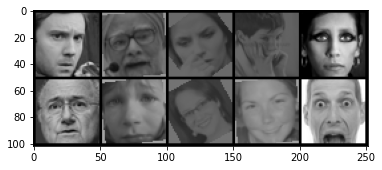

Emotions: ['angry', 'neutral', 'neutral', 'neutral', 'happy', 'surprise', 'happy', 'fear', 'neutral', 'sad']


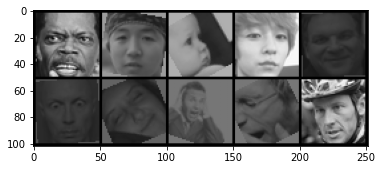

Emotions: ['sad', 'fear', 'angry', 'angry', 'happy', 'happy', 'surprise', 'angry', 'happy', 'surprise']


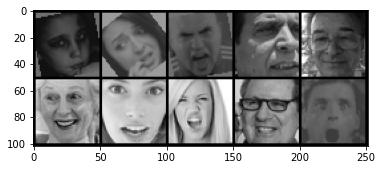

Emotions: ['happy', 'neutral', 'happy', 'fear', 'happy', 'neutral', 'neutral', 'neutral', 'angry', 'surprise']


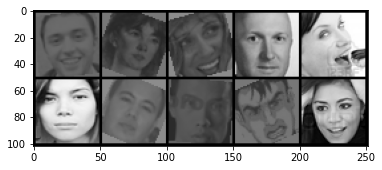

In [25]:
for i, batch in enumerate(vision_train_loader):
    print(f"Emotions: {list(map(lambda e: fer_vision_training.idx_to_class[e.item()], batch.emotions))}")
    grid = make_grid(batch.samples, nrow=5)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    
    if i == 3:
        break

### Further Readings

- [`Randomizable` Transformers](https://docs.monai.io/en/latest/_modules/monai/transforms/compose.html#Randomizable) in `MONAI`

- PyTorch [randomness](https://pytorch.org/docs/stable/notes/randomness.html)

- [Building a Pseudo-Random Number Generator](https://towardsdatascience.com/building-a-pseudorandom-number-generator-9bc37d3a87d5) ❗️

On the choice of _good_ random seeds:

- [C++ Seeding Surprises](https://www.pcg-random.org/posts/cpp-seeding-surprises.html)
- [Effective random seeding of random number generators](https://link.springer.com/content/pdf/10.3758/BF03207952.pdf) (Paper)

___


## DataLoaders and Imbalanced data

As already mentioned in the previous part, the `FER` dataset is a wonderful example of imbalanced data. 

![image.png](https://raw.githubusercontent.com/leriomaggio/pytorch-beautiful-ml-data/main/3_transformer_samplers/imgs/fer_imbalance.png)

Common techniques to cope with imbalanced data usually involve:
- class weighting 
- oversampling

With the _class weighting_ we assign a weight to each class, to be passed to the optimiser, whenever it will be the time to calculate the `loss` on generated predictions. 
The general idea is to penalise **more** errors on the _least_ represented classes.

With _oversampling_, on the other hand, the idea is to try to keep the *same* number of samples in the dataset (and consequently in _batches_) for all the classes. To do so, samples from the minority classes will be _simply repeated_ and included again in the dataset, as they were "other" new samples. 

In this notebook we will discuss a bit of bot, but most importantly, we will have the chance to introduce another object abstraction used by `torch.utils.data` objects: `Sampler`

### Sampler

A `torch.utils.data.Sampler` object is a very simple objects used to specify the **map**, i.e. _the sequence of indices/keys_ used in data loading. 

In fact, a `DataLoader` objects accepts a `sampler` parameter (`None` by default) to be used in combination with the input `Dataset`.

PyTorch provides the following generic `Sampler` classes:

- [`SequentialSampler(data_source)`](https://pytorch.org/docs/stable/data.html?highlight=sequentialsampler#torch.utils.data.SequentialSampler)

- [`RandomSampler(data_source)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.RandomSampler)

- [`SubsetRandomSampler(indices: Sequence[int], generator: torch.Generator = None)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.SubsetRandomSampler)

- [`WeightedRandomSampler(weights: Sequence[float], num_samples, replacement, generator)`](https://pytorch.org/docs/stable/data.html?highlight=randomsampler#torch.utils.data.WeightedRandomSampler)

Their roles, and their use is pretty straightforward.

There exists also a [`BatchSampler`](https://pytorch.org/docs/stable/data.html?highlight=sequentialsampler#torch.utils.data.BatchSampler) which is used by the `DataLoader` in alternative to the `batch_size` if specified (parameter `batch_sampler`)

#### Sampling FER Data

The general idea is to use a `WeightedRandomSampler` for the _training_ data loader to cope with samples imbalance among classes.
To do so, weights for each samples should be calculated, based on their corresponding `class`.

In [26]:
# Adapted from: https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703/2

import numpy as np

def weights_for_balanced_classes(fer_dataset):                        
    n_classes = len(fer_dataset.classes)
    y_true = fer_dataset.targets.cpu().numpy()

    class_count = np.bincount(y_true)
    weights = 1 / class_count[y_true]
    weights /= weights.max()
    return weights, class_count

In [27]:
weights, class_count = weights_for_balanced_classes(fer_vision_training)

In [28]:
# convert in torch tensors
weights = torch.FloatTensor(weights)
class_count = torch.FloatTensor(class_count)

In [36]:
weights

tensor([0.1091, 0.1091, 0.1064,  ..., 0.0903, 0.1091, 0.0903])

In [29]:
from torch.utils.data import WeightedRandomSampler

weighted_sampler = WeightedRandomSampler(weights, num_samples=len(weights), 
                                         replacement=True)  # implements the oversampling

In [30]:
oversampling_loader = DataLoader(fer_vision_training, batch_size=512, 
                                 sampler=weighted_sampler, drop_last=False)

Utility function to plot the count of samples per each classes, as generated by the data loader

In [31]:
from matplotlib.pyplot import cm
color_map = cm.tab10

In [37]:
def plot_class_counts(cls_count, bar_color, title="", class_names=fer_training.classes):
    plt.title(title)
    plt.bar(range(7), cls_count, color=bar_color)
    plt.xticks(range(7), labels=class_names, rotation=90)
    plt.ylim(0, cls_count.max() + 1000)
    for i, c in enumerate(cls_count):
        plt.annotate(text=f"{c:,}", xy=(i-.25, c+200))
    plt.show()

def generate_batches(loader, max_iter: int = 10, label: str ="") -> None:
    for i, batch in enumerate(loader):
        if (i == max_iter):
            break 
        images, labels = batch
        class_count = np.bincount(labels)
        plot_class_counts(class_count, color_map(i), title=f"Class Distribution Batch-{label}-{i+1}")

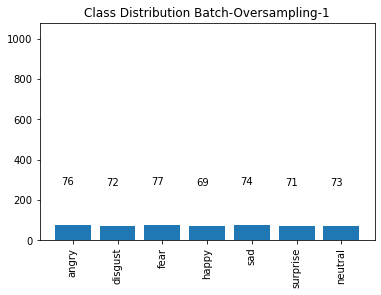

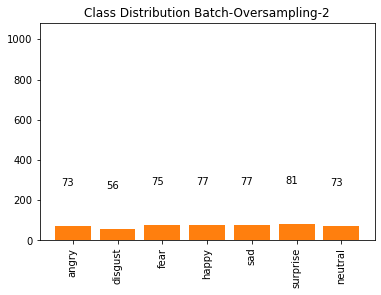

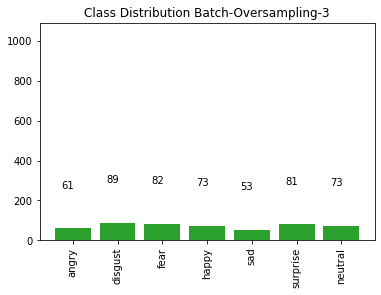

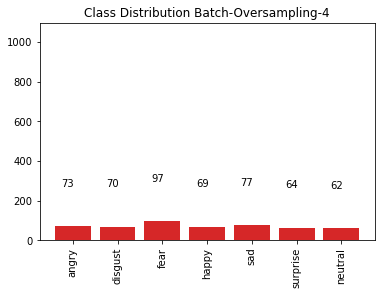

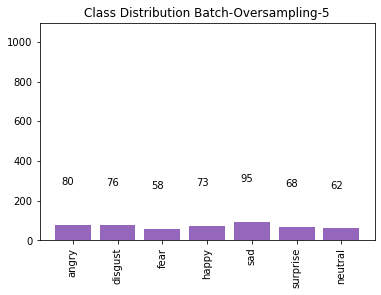

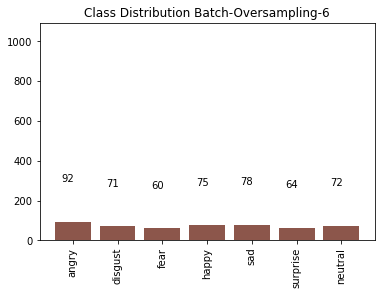

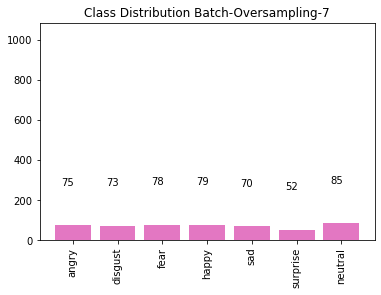

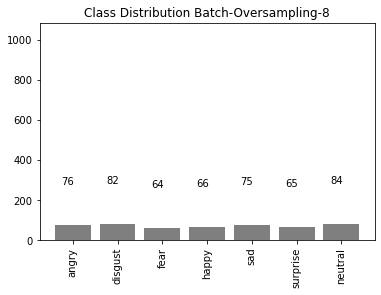

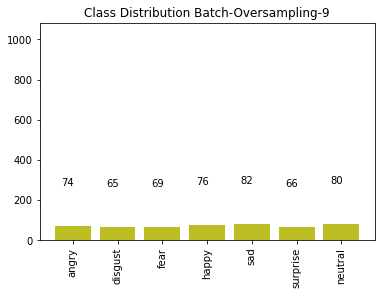

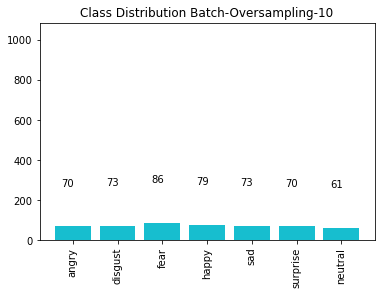

In [38]:
generate_batches(oversampling_loader, label="Oversampling")

As a counter-example, let's try to repeat the very same operations, with a `RandomSampler` (no weights) and with no `sampler` at all!

##### NO Sampler

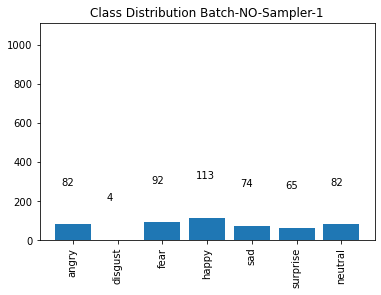

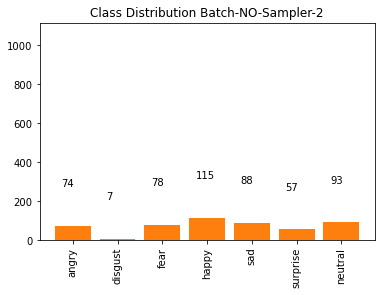

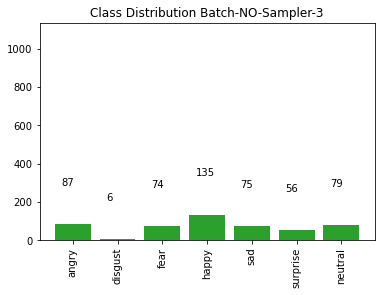

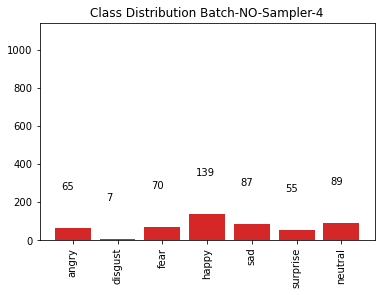

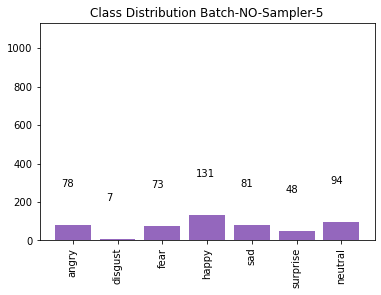

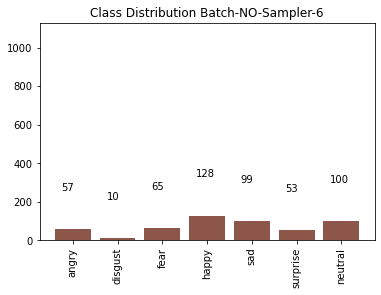

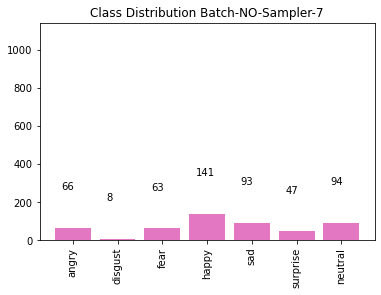

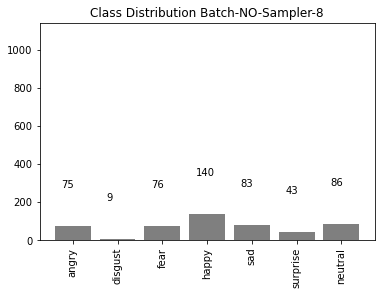

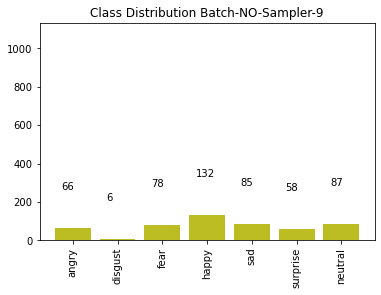

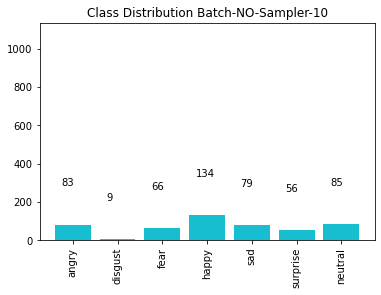

In [39]:
training_loader_no_sampler = DataLoader(fer_vision_training, batch_size=512, drop_last=False)
generate_batches(training_loader_no_sampler, label="NO-Sampler")

##### Random Sampler

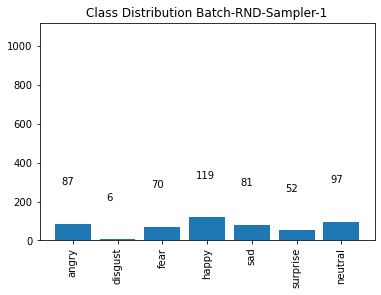

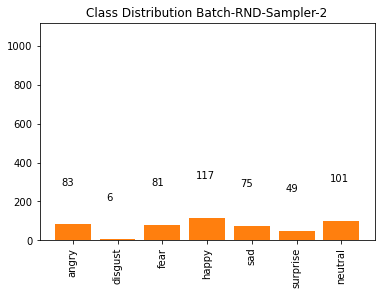

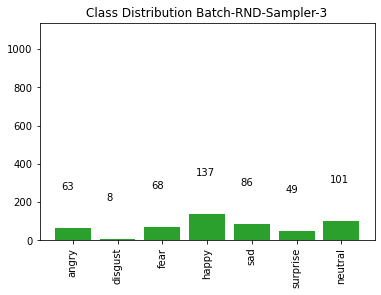

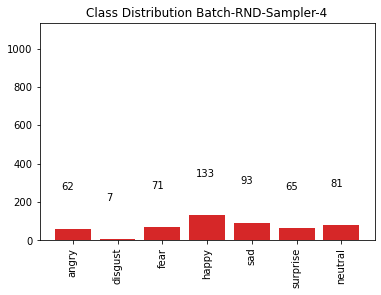

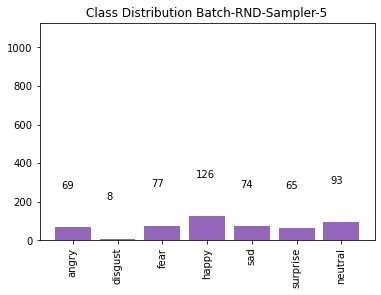

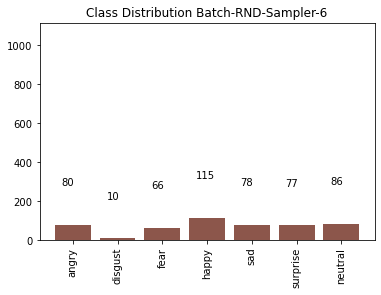

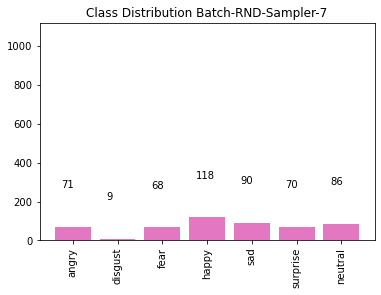

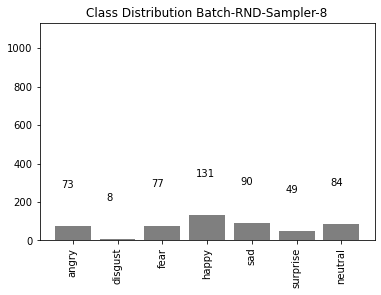

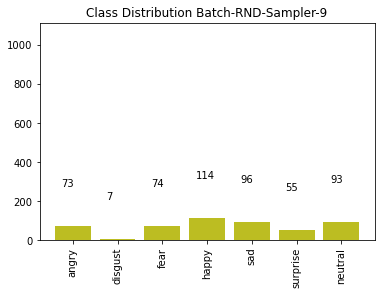

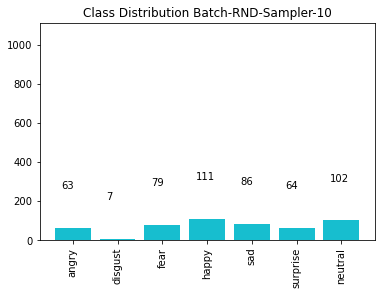

In [40]:
from torch.utils.data import RandomSampler

training_loader_rnd_sampler = DataLoader(fer_vision_training, batch_size=512,
                                         sampler=RandomSampler(fer_vision_training),
                                         drop_last=False)
generate_batches(training_loader_rnd_sampler, label="RND-Sampler")

---